<a href="https://colab.research.google.com/github/Ukbang/Build_with_AI_250405/blob/main/DataAgent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [231]:
!pip install langchain langgraph langchain-google-genai langchain-core langchain-community langchain-experimental koreanize-matplotlib

In [386]:
import pandas as pd
import re
import koreanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from typing import Annotated, Literal
from typing_extensions import TypedDict
from langchain.schema import AIMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnableConfig
from langchain_experimental.tools.python.tool import PythonAstREPLTool
from langgraph.prebuilt import ToolNode
from pydantic import BaseModel, Field
import base64
import io
import os
import warnings

warnings.filterwarnings("ignore")

In [387]:
google_api_key = "" # @param {"type":"string"}

In [388]:
os.environ["google_api_key"] = google_api_key
os.environ["GOOGLE_API_KEY"] = google_api_key

In [389]:
url = "https://raw.githubusercontent.com/Ukbang/Build_with_AI_250405/main/data/titanic.csv"
df = pd.read_csv(url)

In [390]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [438]:
class State(TypedDict):
    messages : Annotated[list, add_messages] # History
    code : Annotated[str, "Python code"]
    code_result : Annotated[str, "Python code Result"]

In [439]:
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash",
                             temperature=0.,
                             convert_system_message_to_human=True,
                             )

tool = PythonAstREPLTool(name="python_repl_ast",
                        description="A Python shell. Use this to execute python commands. \
                                    Input should be a valid python command. When using this tool, \
                                    sometimes output is abbreviated - make sure it does not look abbreviated before using it in your answer.",
                         locals={"df":df})

In [440]:
def create_title_summary(df):

    df_sampled = df.sample(n=5000) if len(df) > 5000 else df

    prompt = PromptTemplate.from_template("""
            당신은 요약 전문가입니다.

            데이터셋 : {df}

            데이터셋의 정보를 보고 제목과 요약을 만들어냅니다.
            제목은 이 데이터셋을 가장 잘 표현할 수 있는 제목으로 결정하여야합니다.

            참고할 정보는 아래와 같습니다.
            """
            f"""
            파일 이름 : {url.split("/")[-1]}

            1. 제목:
            2. 요약:

            """
            )

    chain = prompt | llm

    result = chain.invoke({"df":df_sampled}).content

    title = "Untitled"
    summary = "No Summary"

    try:
        lines = result.split("\n")
        title = lines[0].replace("1. 제목: ", "").strip()
        summary = "\n".join(lines[1:]).replace("2. 요약:", "").strip()
    except:
        pass

    print("===== 제목, 요약 생성 완료 =====\n\n")

    return title, summary

In [441]:
title, summary = create_title_summary(df)

===== 제목, 요약 생성 완료 =====




In [442]:
print("제목 : ", title)
print("요약 : ", summary)

제목 :  ## 타이타닉호 생존자 예측 분석 데이터셋
요약 :  ## 

본 데이터셋은 1912년 타이타닉호 침몰 사고 당시 승객들의 정보를 담고 있으며, 각 승객의 생존 여부를 예측하기 위한 분석에 사용될 수 있습니다. 승객 ID, 생존 여부, 객실 등급, 이름, 성별, 나이, 동반한 형제자매/배우자 수, 동반한 부모/자녀 수, 티켓 번호, 요금, 객실 정보, 승선 항구 등 다양한 변수를 포함하고 있습니다. 891명의 승객 데이터로 구성되어 있으며, 생존 예측 모델 개발 및 관련 인사이트 도출에 활용될 수 있습니다.


In [468]:
llm_with_tools = llm.bind_tools([tool])

In [469]:
class HistoryChecker(BaseModel):
    """
    이전의 대화 기록을 참고하여 질문에 대해 답변할 수 있는지 판단합니다.
    답변할 수 있다면 "yes", 답변할 수 없다면 "no"를 반환합니다.
    """

    yes_no : Literal["yes", "no"] = Field(..., description="""Use your previous conversation history to determine if you can answer your questions.
    Return "yes" if you can answer, "no" if you can't answer.""")

In [470]:
history_checker = llm.with_structured_output(HistoryChecker)

In [471]:
def history_check(state:State):

    prompt = PromptTemplate.from_template("""

                이전의 대화 기록을 참고하여 질문에 대해 답변할 수 있는지 판단합니다.
                답변할 수 있다면 "yes", 답변할 수 없다면 "no"를 반환합니다.

                대화 기록 : {history}

                질문 : {query}

                """)

    chain = prompt | history_checker

    result = chain.invoke({"history":state["messages"][:-1],
                            "query":state["messages"][-1]})

    return result.yes_no

In [472]:
def history_node(state:State):

    return

In [586]:
def select(state:State):
    prompt = PromptTemplate.from_template("""
            당신은 데이터 분석가입니다.
            당신은 데이터프레임인 df를 활용할 수 있습니다.
            당신이 활용 가능한 데이터프레임의 예시는 아래와 같습니다.
            아래의 예시는 `print(df.head())`의 실행결과입니다
            활용 가능한 데이터프레임을 갖고 있으니 데이터프레임을 새로 생성할 필요 없습니다.
            코드에 한글이 필요하다면 `import koreanize_matplotlib`을 사용하세요.

            당신은 'python_repl_ast'라는 파이썬 코드 실행 도구을 가지고 있습니다.
            tool_calls를 할 때에는 'python_repl_ast'만을 사용하세요. 그 외의 다른 도구는 사용하면 안됩니다.
            이를 참고하여 질문에 대한 코드를 생성합니다.

            df : {df}

            title : {title}
            summary : {summary}

            query : {query}
            """
            )

    chain = prompt | llm_with_tools

    result = chain.invoke({"df":df.head(),
                           "title":title,
                            "summary":summary,
                            "query":state["messages"][-1].content})

    if hasattr(result, "tool_calls") and len(result.tool_calls) > 0:
        tool_calls = result.tool_calls

        code = tool_calls[0]["args"]["query"]
        return {"code": code}
    else:
        return {"code":""}

In [587]:
def code_executor(state:State):
    try:
        if ("plt") in state["code"] or ("sns") in state["code"]:
            save_fig = """
import io
import base64

buf = io.BytesIO()
plt.savefig(buf, format="png")
buf.seek(0)

encoded = base64.b64encode(buf.read()).decode("utf-8")

print(encoded)
"""

            execute_code = state["code"] + save_fig

            result = tool.invoke(execute_code)

            return {"code_result":result}
        else:
            result = tool.invoke(state["code"])
            return {"code_result":result}
    except:
        return {"code_result": ""}

In [588]:
def code_response(state:State):
    prompt = ChatPromptTemplate.from_messages([
        ("system", """코드 : {code} \n
                    결과 : {code_result}
        당신은 주어진 코드와 코드 결과를 바탕으로 질의에 대해 답변합니다.
        절대 코드에 대해 설명하지마세요.
        독자는 프로그래머가 아닙니다.
        항상 출력되는 값을 기준으로 설명합니다.
        숫자가 매우 중요합니다. 숫자에 대한 정보를 잊지 마세요.
        데이터 분석과 관련된 코드가 입력된다면 항상 인사이트를 포함하세요. """),
        ("human", '{query}')
    ])

    chain = prompt | llm

    result = chain.invoke({"code":state["code"],
                        "code_result":state["code_result"],
                        "query":state["messages"][-1]})

    return {"answer": result.content,
            "messages": result}

In [589]:
def response(state:State):
    prompt = PromptTemplate.from_template("""

                이전의 대화 기록을 참고하여 질문에 대해 답변하세요.
                아래 대화 기록을 첨부합니다.
                대화 기록을 통해 답변이 어렵다면 내부 지식을 참조하세요.

                대화 기록 : {history}

                질문 : {query}

                """)

    chain = prompt | llm

    result = chain.invoke({"history":state["messages"][:-1],
                           "query":state["messages"][-1]})

    return {"messages":result}

In [590]:
graph_builder = StateGraph(State)

In [591]:
graph_builder.add_node("history_node", history_node)
graph_builder.add_node("select", select)
graph_builder.add_node("code_executor", code_executor)
graph_builder.add_node("code_response", code_response)
graph_builder.add_node("response", response)


graph_builder.add_edge(START, "history_node")
graph_builder.add_conditional_edges("history_node",
                                    history_check,
                                    {
                                    "no":"select",
                                     "yes":"response"
                                     }
                                     )
graph_builder.add_edge("select", "code_executor")
graph_builder.add_edge("code_executor", "code_response")
graph_builder.add_edge("code_response", END)
graph_builder.add_edge("response", END);

In [592]:
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

In [593]:
graph

ReadTimeout: HTTPSConnectionPool(host='mermaid.ink', port=443): Read timed out. (read timeout=10)

In [521]:
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": "1050"})

In [522]:
def streaming(query, config, mode="values"):

    result = graph.stream({"messages":("user", query)}, config=config, stream_mode=mode)

    if mode == "values":
        for step in result:
            for k, v in step.items():
                if k == "messages":
                    v[-1].pretty_print()
    elif mode == "updates":
        for step in result:
            for k,v in step.items():
                print(f"\n\n=== {k} ===\n\n")
                print(v)

    return

================================ Human Message =================================

생존자 비율 시각화하고 인사이트 제공해줘
================================ Human Message =================================

생존자 비율 시각화하고 인사이트 제공해줘


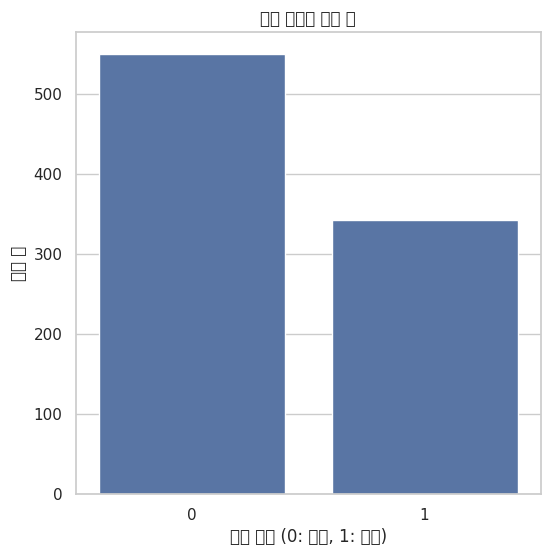

사망 비율: 0.62
생존 비율: 0.38
================================ Human Message =================================

생존자 비율 시각화하고 인사이트 제공해줘
================================== Ai Message ==================================

제공된 코드는 승객의 생존 여부에 따른 수를 시각화하고, 생존 및 사망 비율을 계산하여 출력합니다.

**시각화 결과**

*   **countplot**: 생존 여부(0: 사망, 1: 생존)에 따른 승객 수를 보여주는 막대 그래프가 그려집니다. 그래프를 통해 사망자 수와 생존자 수를 비교할 수 있습니다.

**생존/사망 비율**

*   사망 비율: 0.62
*   생존 비율: 0.38

**인사이트**

타이타닉호 승객의 사망 비율은 62%이고, 생존 비율은 38%입니다. 이를 통해 타이타닉호 사고에서 생존보다 사망한 승객의 수가 더 많았음을 알 수 있습니다.


<Figure size 640x480 with 0 Axes>

In [523]:
streaming("생존자 비율 시각화하고 인사이트 제공해줘", config)

In [524]:
streaming("아까 내가 질문했던 내용 다시 알려줘", config)

================================ Human Message =================================

아까 내가 질문했던 내용 다시 알려줘
================================== Ai Message ==================================

제가 답변했던 내용은 다음과 같습니다.

제공된 코드는 승객의 생존 여부에 따른 수를 시각화하고, 생존 및 사망 비율을 계산하여 출력합니다.

**시각화 결과**

*   **countplot**: 생존 여부(0: 사망, 1: 생존)에 따른 승객 수를 보여주는 막대 그래프가 그려집니다. 그래프를 통해 사망자 수와 생존자 수를 비교할 수 있습니다.

**생존/사망 비율**

*   사망 비율: 0.62
*   생존 비율: 0.38

**인사이트**

타이타닉호 승객의 사망 비율은 62%이고, 생존 비율은 38%입니다. 이를 통해 타이타닉호 사고에서 생존보다 사망한 승객의 수가 더 많았음을 알 수 있습니다.


In [525]:
streaming("아까 물어봤던 숫자들 다 더하면 몇인지 알려줘", config)

================================ Human Message =================================

아까 물어봤던 숫자들 다 더하면 몇인지 알려줘
================================== Ai Message ==================================

이전 대화에서 언급된 숫자는 다음과 같습니다.

*   사망 비율: 0.62
*   생존 비율: 0.38
*   사망 비율 (백분율): 62
*   생존 비율 (백분율): 38

이 숫자들을 모두 더하면 0.62 + 0.38 + 62 + 38 = 101 입니다.


In [540]:
url = "https://raw.githubusercontent.com/Ukbang/Build_with_AI_250405/main/data/athlete_events.csv"
df = pd.read_csv(url)

tool = PythonAstREPLTool(name="python_repl_ast",
                        description="A Python shell. Use this to execute python commands. \
                                    Input should be a valid python command. When using this tool, \
                                    sometimes output is abbreviated - make sure it does not look abbreviated before using it in your answer.",
                        locals={"df":df})

title, summary = create_title_summary(df)

===== 제목, 요약 생성 완료 =====




In [541]:
print("제목 : ", title)
print()
print("요약 : ", summary)

제목 :  1.  **제목:** 올림픽 참가 선수 데이터셋 (1896-2016)

요약 :  2.  **요약:** 이 데이터셋은 1896년부터 2016년까지의 올림픽 참가 선수들의 정보(ID, 이름, 성별, 나이, 키, 몸무게, 소속팀, 국가 올림픽 위원회(NOC), 참가 게임, 연도, 시즌, 개최 도시, 스포츠 종목, 세부 종목, 메달 획득 여부)를 담고 있습니다. 5000개의 샘플 데이터를 통해 올림픽 참가 선수들의 다양한 특징과 메달 획득 현황 등을 분석할 수 있습니다.


In [594]:
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": "99999"})

streaming("올림픽에 출전한 나라는 총 얼마인가요?", config, "updates")



=== history_node ===


None


=== select ===


{'code': "print(df['NOC'].nunique())"}


=== code_executor ===


{'code_result': '230\n'}


=== code_response ===


{'messages': AIMessage(content='올림픽에 출전한 나라는 총 230개국입니다.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run-00e3c76f-3cc9-4b41-9f5a-0337e0ff54ac-0', usage_metadata={'input_tokens': 195, 'output_tokens': 19, 'total_tokens': 214, 'input_token_details': {'cache_read': 0}})}


In [595]:
streaming("가장 많이 출전한 나라는 어디이고 몇 회 출전했나요?", config)

================================ Human Message =================================

가장 많이 출전한 나라는 어디이고 몇 회 출전했나요?
================================ Human Message =================================

가장 많이 출전한 나라는 어디이고 몇 회 출전했나요?
most_frequent_country='USA'
================================ Human Message =================================

가장 많이 출전한 나라는 어디이고 몇 회 출전했나요?
================================== Ai Message ==================================

가장 많이 출전한 나라는 'USA'이고, 총 18853회 출전했습니다. 이는 다른 나라들에 비해 압도적으로 많은 횟수이며, 올림픽 역사에서 미국의 큰 영향력을 보여주는 지표라고 할 수 있습니다.


In [ ]:
df["NOC"].value_counts()

NOC
USA    18853
FRA    12758
GBR    12256
ITA    10715
GER     9830
       ...  
YMD        5
SSD        3
UNK        2
NBO        2
NFL        1
Name: count, Length: 230, dtype: int64

In [596]:
streaming("두 번째로 많이 출전한 나라는 어디인지 알려주세요", config)

================================ Human Message =================================

두 번째로 많이 출전한 나라는 어디인지 알려주세요
================================ Human Message =================================

두 번째로 많이 출전한 나라는 어디인지 알려주세요
================================ Human Message =================================

두 번째로 많이 출전한 나라는 어디인지 알려주세요
================================== Ai Message ==================================

두 번째로 많이 출전한 나라는 프랑스(FRA)이며, 12758번 출전했습니다. 미국(USA)은 18853번 출전하여 가장 많은 출전 횟수를 기록했습니다.

**인사이트:** 미국과 프랑스는 올림픽에 매우 적극적으로 참여하는 국가임을 알 수 있습니다. 특히 미국의 압도적인 출전 횟수는 올림픽 스포츠 강국으로서의 위상을 보여줍니다.


In [597]:
streaming("선수들의 평균 체중은 얼마인가요?", config)

================================ Human Message =================================

선수들의 평균 체중은 얼마인가요?
================================ Human Message =================================

선수들의 평균 체중은 얼마인가요?
================================ Human Message =================================

선수들의 평균 체중은 얼마인가요?
================================== Ai Message ==================================

선수들의 평균 체중은 70.70입니다. 선수들의 체중이 평균적으로 70kg 정도 되는 것을 알 수 있습니다.


In [ ]:
df["Weight"].mean()

70.70239290053351

================================ Human Message =================================

키와 체중, 그리고 메달 획득과의 상관관계를 보여주세요. 산점도 그래프로 그려주세요.
================================ Human Message =================================

키와 체중, 그리고 메달 획득과의 상관관계를 보여주세요. 산점도 그래프로 그려주세요.


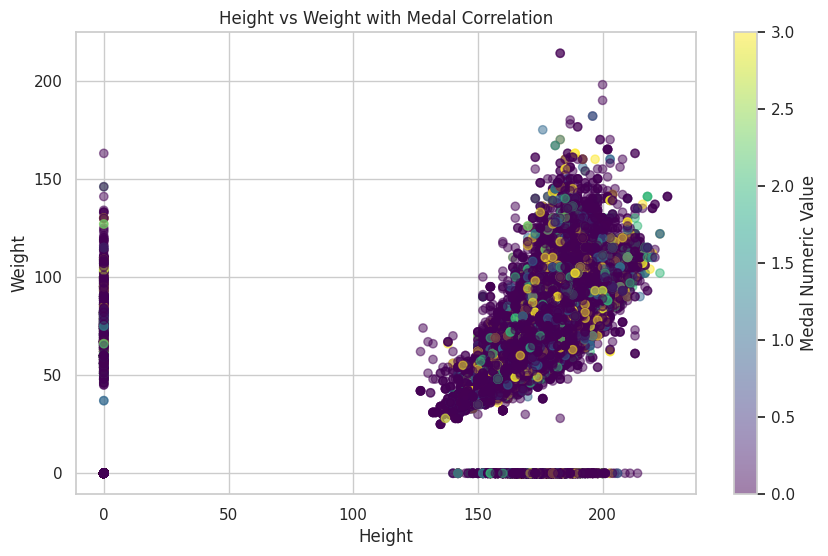

================================ Human Message =================================

키와 체중, 그리고 메달 획득과의 상관관계를 보여주세요. 산점도 그래프로 그려주세요.
================================== Ai Message ==================================

키와 체중의 상관관계를 메달 획득 정보와 함께 시각화한 산점도 그래프입니다.

**그래프의 주요 내용:**

*   **산점도:** 각 점은 선수를 나타내며, 가로축은 키, 세로축은 체중을 나타냅니다.
*   **색상:** 각 점의 색깔은 해당 선수가 획득한 메달 종류를 나타냅니다.
*   **컬러바:** 컬러바는 색상과 메달 종류 사이의 관계를 명확하게 보여줍니다.
*   **투명도:** 점들의 투명도를 조절하여 데이터가 겹쳐 보이는 것을 완화했습니다.

**인사이트:**

*   키와 체중이 클수록 메달을 획득할 가능성이 높아 보입니다.
*   키와 체중은 양의 상관관계를 가집니다. 즉, 키가 클수록 체중도 증가하는 경향이 있습니다.
*   특정 키와 체중 범위에 메달 획득 선수들이 집중되어 있는 것으로 보아, 메달 획득에 유리한 신체 조건이 존재할 수 있음을 시사합니다.


<Figure size 640x480 with 0 Axes>

In [600]:
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": "999"})

streaming("키와 체중, 그리고 메달 획득과의 상관관계를 보여주세요. 산점도 그래프로 그려주세요.", config)